# Preprocessing of raw data

Notebook containing the code to obtain and preprocess the raw data into a smaller or simplified dataset usable for the workshop context.

### OpenStreetMap

Downloaded the .pbf file for Belgium at https://download.geofabrik.de/europe/belgium.html (around 400 MB)

In [2]:
import geopandas
import pyrosm

In [4]:
muni = geopandas.read_file("raw/Voorlopig_referentiebestand_gemeentegrenzen_toestand_17_08_2017_GewVLA_Shape/Shapefile/Refgem.shp")
muniWGS84 = muni.to_crs("EPSG:4326")
gent = muniWGS84[muniWGS84["NAAM"] == "Gent"].geometry.item()

In [5]:
gent.bounds

(3.5797745580829194, 50.97953856271044, 3.849340764693696, 51.18888027930442)

In [7]:
# Initialize the OSM object
osm = pyrosm.OSM("raw/belgium-latest.osm.pbf", bounding_box=list(gent.bounds))

Actually load the data while filtering for Gent, and extract the street network (note: this doesn't take *that* long, around a minute, but requires a lot of available RAM, around 12 GB):

In [10]:
streets = osm.get_network()
streets.to_file("raw/streets.gpkg", driver="GPKG")

Now read this again, and trim the file a bit:

In [16]:
import geopandas

In [17]:
streets = geopandas.read_file("raw/streets.gpkg")

<AxesSubplot:>

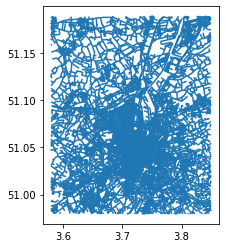

In [18]:
streets.plot()

In [27]:
#subset = streets[["highway", "access", "bicycle", "name", "osm_type", "geometry"]]
subset = streets[["highway", "name", "osm_type", "geometry"]]
subset

,highway,name,osm_type,geometry
0,primary,Oudenaardsesteenweg,way,"LINESTRING (3.70951 51.01845, 3.70951 51.01863..."
1,primary,Krijgslaan,way,"LINESTRING (3.71157 51.02641, 3.71165 51.02642)"
2,residential,Paul Fredericqstraat,way,"LINESTRING (3.71340 51.04028, 3.71338 51.04032..."
3,residential,Meersstraat,way,"LINESTRING (3.71036 51.03886, 3.71041 51.03888)"
4,residential,Jakob Heremansstraat,way,"LINESTRING (3.71154 51.04173, 3.71149 51.04166..."
...,...,...,...,...
27198,pedestrian,Pieter Vanderdoncktdoorgang,way,"LINESTRING (3.73172 51.04893, 3.73140 51.04935)"
27199,residential,Schepenenvijverstraat,way,"LINESTRING (3.73172 51.04893, 3.73141 51.04874..."
27200,residential,Spoorwegstraat,way,"LINESTRING (3.70383 51.10477, 3.70323 51.10458..."
27201,service,None,way,"LINESTRING (3.68146 51.10663, 3.68146 51.10657..."


In [28]:
subset.to_file("osm_network_gent.gpkg", driver="GPKG")

## CORINE Land Cover

Downloaded the raster file from https://land.copernicus.eu/pan-european/corine-land-cover/clc2018?tab=download

In [1]:
import rasterio
import rasterio.windows

In [2]:
with rasterio.open("raw/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif") as src:
    print(src.meta)
    print(src.bounds)

{'driver': 'GTiff', 'dtype': 'int8', 'nodata': -128.0, 'width': 65000, 'height': 46000, 'count': 1, 'crs': CRS.from_epsg(3035), 'transform': Affine(100.0, 0.0, 900000.0,
       0.0, -100.0, 5500000.0)}
BoundingBox(left=900000.0, bottom=900000.0, right=7400000.0, top=5500000.0)


Determine the bounding box of flanders:

In [3]:
import geopandas
flanders = geopandas.read_file("VRBG/RefgemG10.shp")
# converting to same CRS as the raster file
flanders_3035 = flanders.to_crs("EPSG:3035")

In [4]:
flanders_3035.total_bounds

array([3799512.94480779, 3074640.31790764, 4032500.83220125,
       3167919.6130592 ])

Adding a small buffer around it:

In [5]:
from shapely.geometry import box

# 10 km
bounds = box(*flanders_3035.total_bounds).buffer(10000).bounds
bounds

(3789512.944807788, 3064640.317907639, 4042500.832201246, 3177919.613059201)

Rounding it to 100 m (the resolution of the raster file):

In [6]:
bounds = np.round(bounds, -2)  # negative number to specify the number of positions to the *left* of the decimal point.
bounds

array([3789500., 3064600., 4042500., 3177900.])

In [7]:
with rasterio.open("raw/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif") as src:
    arr = src.read(1, window=rasterio.windows.from_bounds(*bounds, src.transform))

In [8]:
arr.shape

(1133, 2530)

Reading a window with rasterio, and writing the cropped raster to a new file:

In [9]:
with rasterio.open("raw/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif") as src:
    window = rasterio.windows.from_bounds(*bounds, src.transform)

    kwargs = src.meta.copy()
    kwargs.update({
        'height': window.height,
        'width': window.width,
        'transform': rasterio.windows.transform(window, src.transform)})

    with rasterio.open('CLC2018_V2020_20u1_flanders.tif', 'w', **kwargs) as dst:
        dst.write(src.read(window=window))

Something similar with xarray (only exploring, not saving):

In [10]:
import xarray

In [11]:
data = xarray.open_rasterio("raw/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif")

In [12]:
data

<xarray.DataArray (band: 1, y: 46000, x: 65000)>
[2990000000 values with dtype=int8]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.5e+06 5.5e+06 5.5e+06 ... 9.002e+05 9.000e+05
  * x        (x) float64 9.000e+05 9.002e+05 9.002e+05 ... 7.4e+06 7.4e+06
Attributes:
    transform:      (100.0, 0.0, 900000.0, 0.0, -100.0, 5500000.0)
    crs:            +init=epsg:3035
    res:            (100.0, 100.0)
    is_tiled:       1
    nodatavals:     (-128.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    DataType:       Thematic

In [13]:
subset = data.sel(x=slice(bounds[0], bounds[2]), y=slice(bounds[3], bounds[1]))

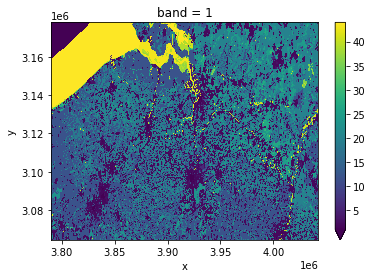

In [14]:
subset.plot(vmin=1, vmax=44)